## Differential Privacy Implementation and Evaluation
This section will implement Differential Privacy with the PySyft library, and evaluate its functionality by comparing loss with original GCN model, and assess its computational complexity in terms of processing time, memory use, and scalability. Further evaluation methods on accuracy, cybersecurity effects will be nominated but not tested and assessed in this study.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import torch
import os
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from neo4j import GraphDatabase

# Connect to Neo4j to retrieve information
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "cexufu01"))

# Define a function to fetch data
def fetch_data(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([record.data() for record in result])

# NEO4J Queries
books_query = "MATCH (b:Book) RETURN b.BookId as BookId, b.Title as Title, b.Author as Author, b.Genre as Genre, b.Publisher as Publisher, b.Year as Year"
users_query = "MATCH (u:User) RETURN u.Username as Username, u.Age as Age, u.Gender as Gender, u.Job as Job, u.Phone_number as Phone_number"
ratings_query = "MATCH (u:User)-[r:RATED]->(b:Book) RETURN u.Username as User, b.BookId as Book, r.Rating as Rating"
followers_query = "MATCH (u1:User)-[:FOLLOWS]->(u2:User) RETURN u1.Username as User1, u2.Username as User2"
authors_query = "MATCH (b:Book)-[:HAS_AUTHOR]-(a:Author) RETURN b.BookId AS Book, a.name AS Author"

# Data
books = fetch_data(books_query)
users = fetch_data(users_query)
ratings = fetch_data(ratings_query)
followers = fetch_data(followers_query)
authors = fetch_data(authors_query)

# Define parameters for differential privacy
epsilon = 0.5  # Privacy parameter
sensitivity = 1.0  # Sensitivity for ratings
age_sensitivity = 10.0  # Sensitivity for age

# Function to add Laplace noise
def add_laplace_noise(data, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, data.shape)
    return data + noise

# Function to anonymize phone numbers
def anonymize_phone_number(phone_number):
    return phone_number[:4] + '****' + phone_number[-4:]

# Add noise to ratings
ratings['Rating'] = add_laplace_noise(ratings['Rating'].values, epsilon, sensitivity)

# Add noise to ages
users['Age'] = add_laplace_noise(users['Age'].values, epsilon, age_sensitivity)

# Anonymize phone numbers
users['Phone_number'] = users['Phone_number'].apply(anonymize_phone_number)

# Showcase the data to prove that the noise has been added and phone numbers are anonymized
print(books.head())
print(users.head())
print(ratings.head())
print(followers.head())
print(authors.head())

  BookId                     Title            Author              Genre  \
0   1001  Fundamentals of Wavelets  Goswami, Jaideva  signal_processing   
1   1002                Data Smart     Foreman, John       data_science   
2   1003  God Created the Integers  Hawking, Stephen        mathematics   
3   1004         Superfreakonomics   Dubner, Stephen          economics   
4   1005               Orientalism      Said, Edward            history   

       Publisher  Year  
0          Wiley  1999  
1          Wiley  2013  
2        Penguin  2005  
3  HarperCollins  2009  
4        Penguin  1978  
  Username        Age  Gender                       Job  Phone_number
0     Adam  72.097581    Male            Data scientist  1-64****4252
1     Bill  39.446091  Female          Theatre director  1-63****8062
2  Charles  59.549419    Male  Teacher, adult education  894.****8126
3     Demi  69.488254  Female              Tour manager  +39(****2187
4     Emma -10.643146  Female  Scientist, water q

In [2]:
class DataPreprocessing:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.book_encoder = LabelEncoder()
        self.scaler = StandardScaler()


    def preprocess_users(self, users):
        user_features = users[['Age', 'Gender', 'Job']].copy()
        user_features['Gender'] = self.user_encoder.fit_transform(user_features['Gender'])
        user_features['Job'] = self.user_encoder.fit_transform(user_features['Job'])
        user_features['Age'] = self.scaler.fit_transform(user_features[['Age']])
        return user_features.values

    def preprocess_books(self, books):
        # Ensure all book features are numeric
        if isinstance(books, list):
            books = pd.DataFrame(books)
            
        book_features = books[['Year', 'Genre', 'Publisher', 'Author']].copy()
        book_features['Genre'] = self.book_encoder.fit_transform(book_features['Genre'])
        book_features['Publisher'] = self.book_encoder.fit_transform(book_features['Publisher'])
        book_features['Author'] = self.book_encoder.fit_transform(book_features['Author'])
        book_features['Year'] = self.scaler.fit_transform(book_features[['Year']])
        return book_features.values

    def combine_features(self, user_features, book_features):
        # Combine features of users and books
        max_features = max(user_features.shape[1], book_features.shape[1])
        user_features = np.pad(user_features, ((0, 0), (0, max_features - user_features.shape[1])), 'constant')
        book_features = np.pad(book_features, ((0, 0), (0, max_features - book_features.shape[1])), 'constant')
        features = np.concatenate((user_features, book_features), axis=0)
        return torch.tensor(features, dtype=torch.float)

    def create_mappings(self, users, books, ratings):
        # Develop a map of user and book
        user_map = {username: idx for idx, username in enumerate(users['Username'])}
        book_map = {book_id: idx + len(users) for idx, book_id in enumerate(books['BookId'])}

        # Created a user-rated-book set
        self.user_rated_books = {user: [] for user in user_map.keys()}
        for _, row in ratings.iterrows():
            self.user_rated_books[row['User']].append(row['Book'])

        # Calculate book popularity
        self.book_popularity = ratings['Book'].value_counts().to_dict()
    
        # Calculate user reading frequency
        self.user_reading_frequency = ratings['User'].value_counts().to_dict()
            
        return user_map, book_map, self.user_rated_books, self.book_popularity, self.user_reading_frequency

    def preprocess_data(self, users, books, ratings, followers):
        user_features = self.preprocess_users(users)
        book_features = self.preprocess_books(books)
        features = self.combine_features(user_features, book_features)
        user_map, book_map, self.user_rated_books, self.book_popularity, self.user_reading_frequency = self.create_mappings(users, books, ratings)
        edge_index, edge_weight, rule_scores, user_preferences = self.build_graph_data(ratings, followers, user_map, book_map)
        return features, user_map, book_map, self.user_rated_books, edge_index, edge_weight, rule_scores, user_preferences

    def build_graph_data(self, ratings, followers, user_map, book_map):
        edge_index = []
        edge_weight = []
        rule_scores = []
        user_preferences = {}

        for _, row in ratings.iterrows():
            user_idx = user_map[row['User']]
            book_idx = book_map[row['Book']]
            edge_index.append([user_idx, book_idx]) 
            edge_weight.append(row['Rating']) 

            # INitiate user preference
            if user_idx not in user_preferences:
                user_preferences[user_idx] = {'genres': {}, 'authors': {}}
            
            # Get genre and author as indicators and sources for preference analyses
            genre = books.loc[books['BookId'] == row['Book'], 'Genre'].values[0]
            author = books.loc[books['BookId'] == row['Book'], 'Author'].values[0]
            rating = row['Rating']

            # Updating users preferences
            if genre not in user_preferences[user_idx]['genres']:
                user_preferences[user_idx]['genres'][genre] = []
            if author not in user_preferences[user_idx]['authors']:
                user_preferences[user_idx]['authors'][author] = []
            user_preferences[user_idx]['genres'][genre].append(rating)
            user_preferences[user_idx]['authors'][author].append(rating)

            # Calculating the score of preferences
            user_age = users.loc[users['Username'] == row['User'], 'Age'].values[0]
            user_job = users.loc[users['Username'] == row['User'], 'Job'].values[0]
            book_year = books.loc[books['BookId'] == row['Book'], 'Year'].values[0]
        
            author_score = self.calculate_author_score(user_preferences[user_idx]['authors'], author, rating)
            genre_score = self.calculate_genre_score(user_preferences[user_idx]['genres'], genre, rating)
            age_score = self.calculate_age_score(user_age, book_year)
            friend_score = self.calculate_friend_score(row['User'], book_idx, ratings, followers, user_map, book_map)
            age_group_score = self.calculate_age_group_score(user_age, row['Book'], ratings)
            job_score = self.calculate_job_score(user_job, book_idx, ratings)
            reading_frequency_score = self.calculate_reading_frequency_score(row['User'])
            book_popularity_score = self.calculate_book_popularity_score(row['Book'])

            total_score = author_score + genre_score + age_score + friend_score + age_group_score + job_score +reading_frequency_score + book_popularity_score
            rule_scores.append(total_score)

        for _, row in followers.iterrows():
            follower_idx = user_map[row['User1']]
            followee_idx = user_map[row['User2']]
            edge_index.append([follower_idx, followee_idx])
            edge_weight.append(1)  #  followership is also considered

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        rule_scores = torch.tensor(rule_scores, dtype=torch.float)

        return edge_index, edge_weight, rule_scores, user_preferences

    def calculate_author_score(self, user_authors, author, rating):
        if author not in user_authors:
            return 0
        avg_rating = sum(user_authors[author]) / len(user_authors[author])
        if avg_rating == 5:
            return 25
        elif avg_rating == 4:
            return 20
        elif avg_rating == 3:
            return 15
        elif avg_rating == 2:
            return -10
        elif avg_rating == 1:
            return -25
        else:
            return 0

    def calculate_genre_score(self, user_genres, genre, rating):
        if genre not in user_genres:
            return 0
        avg_rating = sum(user_genres[genre]) / len(user_genres[genre])
        if avg_rating == 5:
            return 15
        elif avg_rating == 4:
            return 10
        elif avg_rating == 3:
            return 5
        elif avg_rating == 2:
            return -5
        elif avg_rating == 1:
            return -10
        else:
            return 0

    def calculate_age_score(self, user_age, book_year):
        user_age = int(user_age)  # Ensure user_age is an integer
        book_year = int(book_year)  # Ensure book_year is an integer
        age_diff = abs(2024 - book_year - user_age)
        if age_diff > 50:
            return -10
        elif age_diff > 20:
            return -5
        else:
            return 10

    def calculate_friend_score(self, user, book_idx, ratings, followers, user_map, book_map):
        friend_score = 0
        followers = followers[followers['User1'] == user]
        for _, row in followers.iterrows():
            followee = row['User2']
            followee_idx = user_map[followee]
            rating = ratings[(ratings['User'] == followee) & (ratings['Book'] == book_idx)]['Rating'].mean()
            if not pd.isna(rating):
                if rating == 5:
                    friend_score += 25 / 2
                elif rating == 4:
                    friend_score += 20 / 3
                elif rating == 3:
                    friend_score += 15 / 4
                elif rating == 2:
                    friend_score += -10 / 5
                elif rating == 1:
                    friend_score += -25 / 6
        return friend_score

    def calculate_age_group_score(self, user_age, book_idx, ratings):
        user_age_group = user_age // 10 * 10
        age_group_ratings = ratings[ratings['User'].apply(lambda x: users.loc[users['Username'] == x, 'Age'].values[0] // 10 * 10) == user_age_group]
        book_ratings = age_group_ratings[age_group_ratings['Book'] == book_idx]['Rating']
        if len(book_ratings) > 0 and (book_ratings > 2).mean() > 0.5:
            return 20
        elif len(book_ratings) > 0 and (book_ratings <= 2).mean() > 0.5:
            return -10
        return 0

    def calculate_job_score(self, user_job, book_idx, ratings):
        job_ratings = ratings[ratings['User'].apply(lambda x: users.loc[users['Username'] == x, 'Job'].values[0]) == user_job]
        book_ratings = job_ratings[job_ratings['Book'] == book_idx]['Rating']
        if len(book_ratings) > 0 and (book_ratings > 2).mean() > 0.5:
            return 20
        elif len(book_ratings) > 0 and (book_ratings <= 2).mean() > 0.5:
            return -10
        return 0

    def calculate_reading_frequency_score(self, user):
        # Determine top 25% threshold for reading frequency
        reading_frequency_threshold = np.percentile(list(self.user_reading_frequency.values()), 75)
        if self.user_reading_frequency.get(user, 0) > reading_frequency_threshold:
            return 8  # Frequent readers
        else:
            return 5  # Infrequent readers
    
    def calculate_book_popularity_score(self, book_idx):
        """
        Calculate the book popularity score for a given book based on its overall popularity.
        """
        # Determine top 25% threshold for book popularity
        book_popularity_threshold = np.percentile(list(self.book_popularity.values()), 75)
        if self.book_popularity.get(book_idx, 0) > book_popularity_threshold:
            return 8  # Popular books
        else:
            return -5  # Less popular books

    def rating_to_score(self, avg_rating):
        if avg_rating == 5:
            return 25
        elif avg_rating == 4:
            return 20

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, noise_scale):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)  # output the recommendation scores
        self.noise_scale = noise_scale  # Parameter to control the scale of added noise

    def forward(self, x, edge_index, user_preferences=None, rule_scores=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        if user_preferences is not None:
            preference_embedding = self.get_preference_embedding(user_preferences, x.shape[0])
            preference_embedding = self.add_noise(preference_embedding)  # Add noise to preference embeddings
            x += preference_embedding
        
        if rule_scores is not None:
            rule_scores = rule_scores[:x.shape[0]]
            rule_scores = self.add_noise(rule_scores)  # Add noise to rule scores
            x += rule_scores.unsqueeze(1)
            
        return x

    def add_noise(self, tensor):
        noise = torch.randn_like(tensor) * self.noise_scale
        return tensor + noise

    def get_preference_embedding(self, user_preferences, num_nodes):
        '''
        This function will generate user preference and embed into the system with weighting
        '''
        preference_embedding = torch.zeros(num_nodes, self.linear.out_features)
        for user_idx, preferences in user_preferences.items():
            for genre, ratings in preferences['genres'].items():
                preference_embedding[user_idx] += sum(ratings) / len(ratings)
            for author, ratings in preferences['authors'].items():
                preference_embedding[user_idx] += sum(ratings) / len(ratings)
        return preference_embedding

    def predict(self, x, user_idx, book_idx, user_preferences=None, rule_scores=None):
        edge_index = torch.tensor([[user_idx, book_idx], [book_idx, user_idx]], dtype=torch.long).t().contiguous()
        x = self.forward(x, edge_index)

        if user_preferences is not None:
            preference_embedding = self.get_preference_embedding(user_preferences, x.shape[0])
            preference_embedding = self.add_noise(preference_embedding)  # Add noise to preference embeddings
            x += preference_embedding
        
        if rule_scores is not None:
            rule_scores = rule_scores[:x.shape[0]]
            rule_scores = self.add_noise(rule_scores)  # Add noise to rule scores
            x += rule_scores.unsqueeze(1)

        # Here we take the representation of the book node to get the score
        x_book = x[book_idx].unsqueeze(0)
        x = self.linear(x_book)
        return x.squeeze().item()

In [4]:
import torch
import torch.nn.functional as F
import psutil
import os
import time
import matplotlib.pyplot as plt

class GCNTrainer:
    def __init__(self, model_class, features, user_map, book_map, user_preferences, rule_scores, user_rated_books, noise_scale, patience=10):
        """
        Initialize the GCNTrainer with model, features, user and book mappings, user preferences, rule scores,
        a single noise scale for differential privacy, and patience for early stopping.

        Parameters:
        - model_class: The class of the GCN model to be trained and evaluated.
        - features: Tensor of node features.
        - user_map: Dictionary mapping users to their indices.
        - book_map: Dictionary mapping books to their indices.
        - user_preferences: Dictionary of user preferences.
        - rule_scores: Additional scores based on the six rules.
        - noise_scale: Scale of Gaussian noise to add.
        - patience: Number of epochs to wait for early stopping.
        """
        self.model_class = model_class
        self.features = features
        self.user_map = user_map
        self.book_map = book_map
        self.user_preferences = user_preferences
        self.rule_scores = rule_scores
        self.noise_scale = noise_scale
        self.user_rated_books = user_rated_books
        self.patience = patience
        self.model = self.model_class(in_channels=features.shape[1], hidden_channels=256, out_channels=128, noise_scale=self.noise_scale)

    def get_memory_usage(self):
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return mem_info.rss / (1024 * 1024)  # Return memory usage in MB

    def train_and_evaluate_model(self, features, edge_index, edge_weight, epochs=100, lr=0.001):
        """
        Train and evaluate the GCN model for a single noise scale.

        Parameters:
        - features: Tensor of node features.
        - edge_index: Edge index tensor for the data set.
        - edge_weight: Edge weight tensor for the data set.
        - epochs: Number of training epochs.
        - lr: Learning rate for the optimizer.

        Returns:
        - results: Dictionary containing loss, runtime, and memory usage for the noise scale.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        patience_counter = 0
        train_losses = []
        results = {}

        start_time = time.time()

        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            out = self.model(features, edge_index, user_preferences=self.user_preferences, rule_scores=self.rule_scores)
            
            # Add noise to the output for differential privacy
            out_noisy = self.add_noise(out)

            # Calculate loss for both rating and follower edges
            rating_mask = edge_weight > 1  # Assuming rating edges have weight > 1
            follower_mask = edge_weight == 1  # Assuming follower edges have weight == 1

            rating_out = out_noisy[edge_index[1][rating_mask]].squeeze()
            rating_out = rating_out.mean(dim=1)  # Average over the output dimension to match target shape
            rating_loss = F.mse_loss(rating_out, edge_weight[rating_mask].squeeze())

            follower_out = out_noisy[edge_index[0][follower_mask]].squeeze()
            follower_out = follower_out.mean(dim=1)  # Average over the output dimension to match target shape
            follower_loss = F.mse_loss(follower_out, out_noisy[edge_index[1][follower_mask]].squeeze().mean(dim=1))

            loss = rating_loss + follower_loss
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        end_time = time.time()
        runtime = end_time - start_time
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # Memory usage in MB
        
        results[self.noise_scale] = {
            'train_losses': train_losses,
            'runtime': runtime,
            'memory_usage': memory_usage,
        }

        return results

    def add_noise(self, out):
        """
        Add Gaussian noise to the output tensor for differential privacy.
    
        Parameters:
        - out: Tensor of model outputs.
    
        Returns:
        - Noisy tensor.
        """
        if self.noise_scale > 0:
            noise = torch.randn_like(out) * self.noise_scale
            return out + noise
        return out

    def plot_results(self, results):
        """
        Plot the results of training for the single noise scale.

        Parameters:
        - results: Dictionary containing loss, runtime, and memory usage for the noise scale.
        """
        noise_scales = list(results.keys())
        train_losses = [min(results[scale]['train_losses']) for scale in noise_scales]
        runtimes = [results[scale]['runtime'] for scale in noise_scales]
        memory_usages = [results[scale]['memory_usage'] for scale in noise_scales]

        plt.figure(figsize=(15, 10))

        # Plot train losses
        plt.subplot(3, 1, 1)
        plt.plot(noise_scales, train_losses, marker='o', linestyle='-', color='b')
        plt.xlabel('Noise Scale')
        plt.ylabel('Train Loss')
        plt.title('Train Loss vs. Noise Scale')
        plt.grid(True)

        # Plot runtimes
        plt.subplot(3, 1, 2)
        plt.plot(noise_scales, runtimes, marker='o', linestyle='-', color='r')
        plt.xlabel('Noise Scale')
        plt.ylabel('Runtime (s)')
        plt.title('Runtime vs. Noise Scale')
        plt.grid(True)

        # Plot memory usage
        plt.subplot(3, 1, 3)
        plt.plot(noise_scales, memory_usages, marker='o', linestyle='-', color='g')
        plt.xlabel('Noise Scale')
        plt.ylabel('Memory Usage (MB)')
        plt.title('Memory Usage vs. Noise Scale')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def recommend_books(self, top_k=5):
        """
        Recommend books for each user based on the trained GCN model.

        Parameters:
        - top_k: Number of top recommendations to return for each user.

        Returns:
        - recommendations: Dictionary mapping each user to a list of recommended book IDs.
        """
        self.model.eval()
        recommendations = {}
        with torch.no_grad():
            user_indices = list(self.user_map.values())
            book_indices = list(self.book_map.values())

            for user_id, user_idx in self.user_map.items():
                scores = []
                rated_books = set(self.user_rated_books.get(user_id, []))
                for book_id, book_idx in self.book_map.items():
                    if book_id not in rated_books: # make sure that the recommended book is not read or rated
                        score = self.model.predict(self.features, user_idx, book_idx, user_preferences=self.user_preferences, rule_scores=self.rule_scores)
                        scores.append((book_id, score))
            
                # Sort the scores and get the top_k books
                scores.sort(key=lambda x: x[1], reverse=True)
                top_books = [book_id for book_id, _ in scores[:top_k]]
                recommendations[user_id] = top_books

        return recommendations

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import psutil
import os
import matplotlib.pyplot as plt

# 确保数据为 DataFrame
if not isinstance(users, pd.DataFrame):
    users = pd.DataFrame(users)
if not isinstance(books, pd.DataFrame):
    books = pd.DataFrame(books)
if not isinstance(ratings, pd.DataFrame):
    ratings = pd.DataFrame(ratings)
if not isinstance(followers, pd.DataFrame):
    followers = pd.DataFrame(followers)

# 函数用于获取当前内存使用情况
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)  # 返回内存使用量，以MB为单位

# 定义噪音尺度范围
noise_scales = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 30.0, 50.0, 75.0, 100.0, 200.0]

# 初始化记录列表
memory_usage_log = []
runtime_log = []
loss_log = []

# 记录开始
start_time = time.time()
memory_usage_log.append(('Start', get_memory_usage()))

# 初始化预处理器和模型管理器
preprocessor = DataPreprocessing()
model_class = GCN  # Assuming GCN is already defined

# 预处理数据
print("Starting data preprocessing...")
features, user_map, book_map, user_rated_books, edge_index, edge_weight, rule_scores, user_preferences = preprocessor.preprocess_data(users, books, ratings, followers)
print('Data preprocessing finished')

Starting data preprocessing...
Data preprocessing finished


In [6]:
# 记录数据预处理后的内存使用
memory_usage_log.append(('Post preprocessing', get_memory_usage()))

# 确保 edge_index 和 edge_weight 的形状一致
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_weight length: {len(edge_weight)}")

# 检查 edge_index 和 edge_weight 是否一致
assert edge_index.shape[1] == len(edge_weight), "edge_index and edge_weight lengths do not match."

edge_index shape: torch.Size([2, 386])
edge_weight length: 386


Testing noise scale: 0.0
Testing noise scale: 0.01
Testing noise scale: 0.05
Testing noise scale: 0.1
Testing noise scale: 0.25
Testing noise scale: 0.5
Testing noise scale: 0.75
Testing noise scale: 1.0
Testing noise scale: 1.5
Testing noise scale: 2.0
Testing noise scale: 3.0
Testing noise scale: 5.0
Testing noise scale: 10.0
Testing noise scale: 30.0
Testing noise scale: 50.0
Testing noise scale: 75.0
Testing noise scale: 100.0
Testing noise scale: 200.0
Total runtime: 154.70 seconds


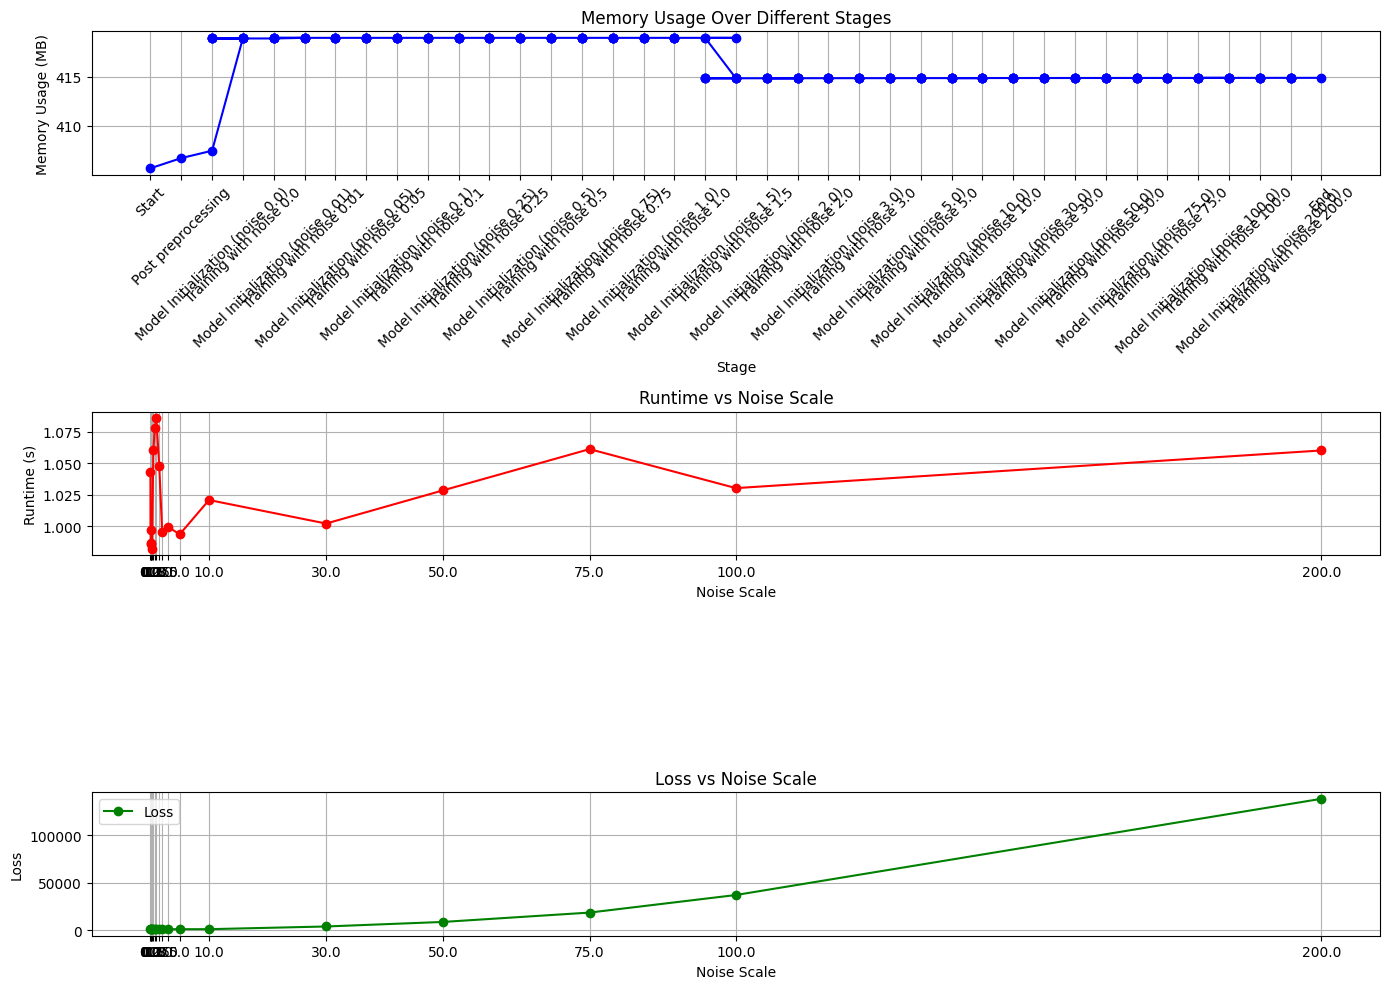

In [7]:
# 初始化模型训练类
results = {}

# 设置重复次数
repeats = 5

# 在不同的噪音尺度下训练和评估模型
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    all_losses = []
    all_runtimes = []
    
    for _ in range(repeats):
        # 初始化GCNTrainer
        trainer = GCNTrainer(model_class, features, user_map, book_map, user_preferences, rule_scores, user_rated_books, noise_scale, patience=10)

        # 记录模型初始化后的内存使用情况
        memory_usage_log.append((f'Model Initialization (noise {noise_scale})', get_memory_usage()))

        # 记录开始训练时间
        start_training_time = time.time()

        # 训练并评估
        result = trainer.train_and_evaluate_model(features, edge_index, edge_weight)
        results.update(result)

        # 记录训练时间
        end_training_time = time.time()
        runtime = end_training_time - start_training_time
        all_runtimes.append(runtime)
        
        # 记录损失值
        train_loss = min(result[noise_scale]['train_losses'])  # 通过最小化验证损失获取
        all_losses.append(train_loss)
        
        # 记录训练后的内存使用情况
        memory_usage_log.append((f'Training with noise {noise_scale}', get_memory_usage()))
    
    # 记录平均损失和运行时间
    avg_loss = np.mean(all_losses)
    avg_runtime = np.mean(all_runtimes)
    
    runtime_log.append((noise_scale, avg_runtime))
    loss_log.append((noise_scale, avg_loss))

# 记录结束时间和内存使用情况
end_time = time.time()
memory_usage_log.append(('End', get_memory_usage()))
print(f"Total runtime: {end_time - start_time:.2f} seconds")

# 绘制内存变化的折线图
stages, memory_usages = zip(*memory_usage_log)

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(stages, memory_usages, marker='o', linestyle='-', color='b')
plt.xlabel('Stage')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Over Different Stages')
plt.xticks(rotation=45)
plt.grid(True)

# 绘制不同噪音尺度下的运行时间
noise_scales, runtimes = zip(*runtime_log)
plt.subplot(3, 1, 2)
plt.plot(noise_scales, runtimes, marker='o', linestyle='-', color='r', label='Runtime')
plt.xlabel('Noise Scale')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs Noise Scale')
plt.xticks(noise_scales)
plt.grid(True)

# 绘制不同噪音尺度下的损失曲线
noise_scales, losses = zip(*loss_log)
plt.subplot(3, 1, 3)
plt.plot(noise_scales, losses, marker='o', linestyle='-', color='g', label='Loss')
plt.xlabel('Noise Scale')
plt.ylabel('Loss')
plt.title('Loss vs Noise Scale')
plt.xticks(noise_scales)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Testing noise scale: 0.0
Testing noise scale: 0.25
Testing noise scale: 0.5
Testing noise scale: 0.75
Testing noise scale: 1.0
Testing noise scale: 1.5
Testing noise scale: 2.0
Testing noise scale: 3.0
Testing noise scale: 4.0
Testing noise scale: 5.0
Testing noise scale: 6.0
Testing noise scale: 7.0
Testing noise scale: 8.0
Testing noise scale: 9.0
Testing noise scale: 10.0
Testing noise scale: 11.0
Total runtime: 199.35 seconds


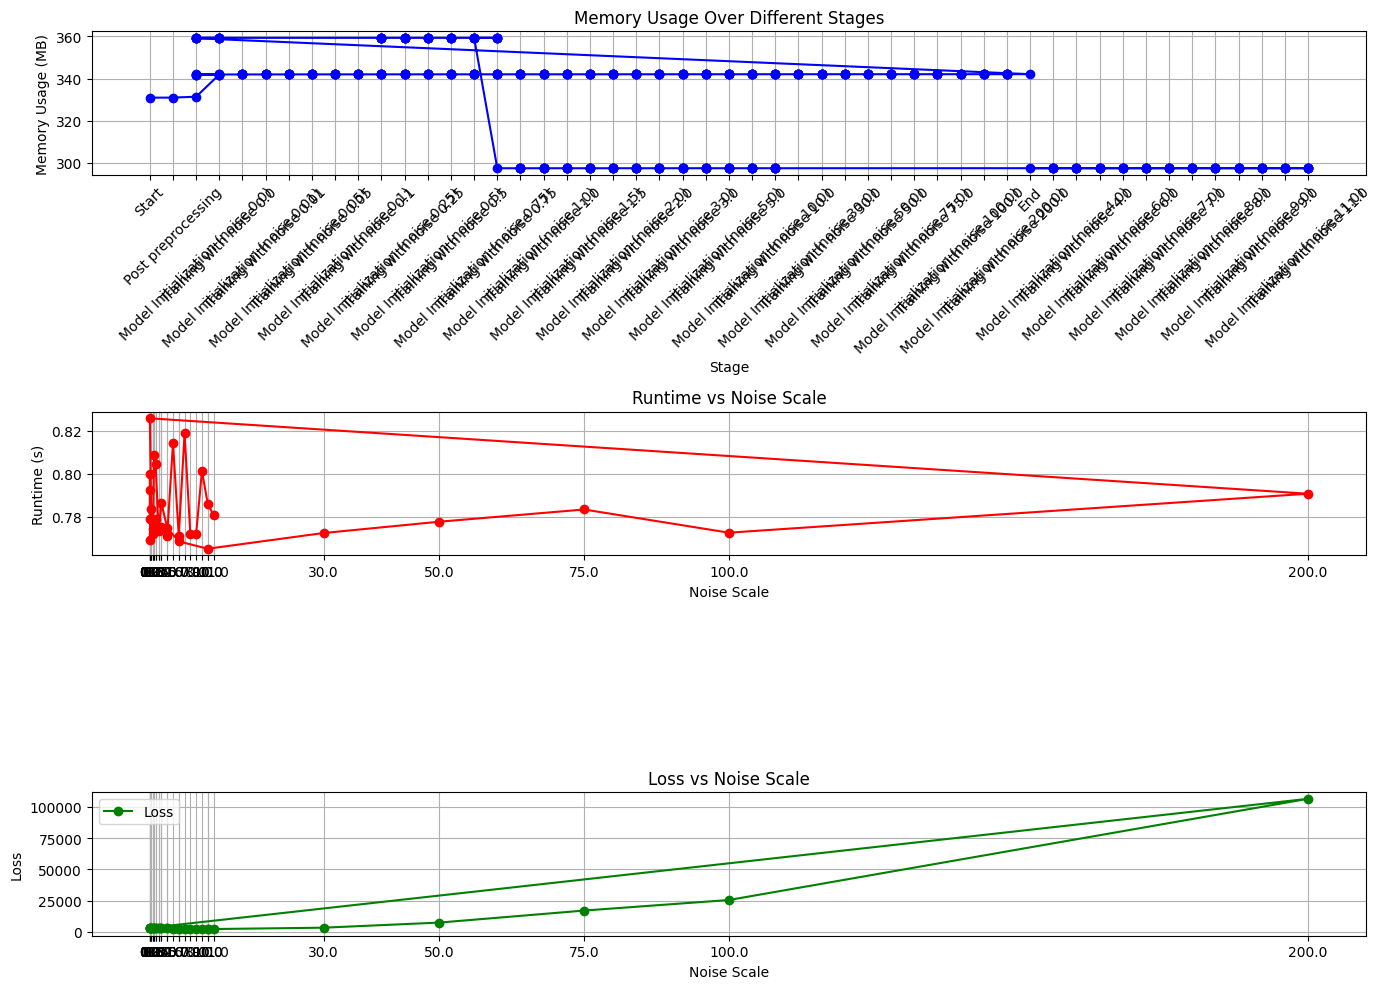

In [20]:
# Reset noise scales to generate small-size maps
noise_scales = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

# 初始化模型训练类
results = {}

# 设置重复次数
repeats = 5

# 在不同的噪音尺度下训练和评估模型
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    all_losses = []
    all_runtimes = []
    
    for _ in range(repeats):
        # 初始化GCNTrainer
        trainer = GCNTrainer(model_class, features, user_map, book_map, user_preferences, rule_scores, user_rated_books, noise_scale, patience=10)

        # 记录模型初始化后的内存使用情况
        memory_usage_log.append((f'Model Initialization (noise {noise_scale})', get_memory_usage()))

        # 记录开始训练时间
        start_training_time = time.time()

        # 训练并评估
        result = trainer.train_and_evaluate_model(features, edge_index, edge_weight)
        results.update(result)

        # 记录训练时间
        end_training_time = time.time()
        runtime = end_training_time - start_training_time
        all_runtimes.append(runtime)
        
        # 记录损失值
        train_loss = min(result[noise_scale]['train_losses'])  # 通过最小化验证损失获取
        all_losses.append(train_loss)
        
        # 记录训练后的内存使用情况
        memory_usage_log.append((f'Training with noise {noise_scale}', get_memory_usage()))
    
    # 记录平均损失和运行时间
    avg_loss = np.mean(all_losses)
    avg_runtime = np.mean(all_runtimes)
    
    runtime_log.append((noise_scale, avg_runtime))
    loss_log.append((noise_scale, avg_loss))

# 记录结束时间和内存使用情况
end_time = time.time()
memory_usage_log.append(('End', get_memory_usage()))
print(f"Total runtime: {end_time - start_time:.2f} seconds")

# 绘制内存变化的折线图
stages, memory_usages = zip(*memory_usage_log)

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(stages, memory_usages, marker='o', linestyle='-', color='b')
plt.xlabel('Stage')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage Over Different Stages')
plt.xticks(rotation=45)
plt.grid(True)

# 绘制不同噪音尺度下的运行时间
noise_scales, runtimes = zip(*runtime_log)
plt.subplot(3, 1, 2)
plt.plot(noise_scales, runtimes, marker='o', linestyle='-', color='r', label='Runtime')
plt.xlabel('Noise Scale')
plt.ylabel('Runtime (s)')
plt.title('Runtime vs Noise Scale')
plt.xticks(noise_scales)
plt.grid(True)

# 绘制不同噪音尺度下的损失曲线
noise_scales, losses = zip(*loss_log)
plt.subplot(3, 1, 3)
plt.plot(noise_scales, losses, marker='o', linestyle='-', color='g', label='Loss')
plt.xlabel('Noise Scale')
plt.ylabel('Loss')
plt.title('Loss vs Noise Scale')
plt.xticks(noise_scales)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Scalability Test

This section will test the model with different size of datasets, and it will be controlled by a defined dataset generation. Notably, the original dataset will not be included in the new dataset, but its numbers of nodes, relations, ratios of node-to-edge, and ratios of raintg-to-follower, ratios of book-to-user will be used to control the data structure.

In [8]:
# calculate the nnumbers of nodes and relations on original dataset
num_books =books['BookId'].nunique()
num_users = users['Username'].nunique()
book_user_ratio = num_books / num_users

num_ratings = ratings.shape[0]
num_followers = followers. shape[0]
follower_rating_ratio = num_followers / num_ratings

num_nodes = users['Username'].nunique() + books['BookId'].nunique()
num_edges = ratings.shape[0] + followers.shape[0]

# the graph sparsity
user_user_max_edges = users['Username'].nunique() * (users['Username'].nunique() - 1)
user_book_max_edges = users['Username'].nunique() * books['BookId'].nunique()
max_edges = user_user_max_edges + user_book_max_edges
sparsity = (1 - (num_edges / max_edges))

# output genre to set a range of possible genres of books
genres = set(books['Genre'])

print(f'The original dataset contains {num_nodes} nodes, {num_edges} edges, and the graph sparsity is {sparsity:.2%}. the book user ratio is {book_user_ratio:.2%}, the follower ratings ratio is {follower_rating_ratio:.2%}')
print(f'possible genres are {genres}.')

The original dataset contains 121 nodes, 386 edges, and the graph sparsity is 87.63%. the book user ratio is 365.38%, the follower ratings ratio is 34.97%
possible genres are {'signal_processing', 'philosophy', 'data_science', 'mathematics', 'fiction', 'economics', 'psychology', 'nonfiction', 'history', 'computer_science', 'science'}.


In [9]:
import pandas as pd
import random
from faker import Faker

fake = Faker()

def add_laplace_noise(data, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, data.shape)
    return data + noise

def anonymize_phone_number(phone_number):
    return phone_number[:4] + '****' + phone_number[-4:]

def generate_dataset(follower_rating_ratio, book_user_ratio, sparsity, num_nodes, genres, epsilon=0.5, sensitivity=1.0, age_sensitivity=10.0):

    # Calculate the numbers of nodes and relations respectively based on the provided ratios and numbers
    num_books = int(num_nodes * book_user_ratio / (1 + book_user_ratio))
    num_users = num_nodes - num_books
    num_edges = int((1 - sparsity) * num_users * (num_users - 1 + num_books))
    num_ratings = int(num_edges / (1 + follower_rating_ratio))
    num_follows = num_edges - num_ratings
    
    users = pd.DataFrame({
        'Username': [fake.user_name() for _ in range(num_users)],
        'Age': [random.randint(18, 70) for _ in range(num_users)],
        'Gender': [random.choice(['Male', 'Female']) for _ in range(num_users)],
        'Job': [fake.job() for _ in range(num_users)],
        'Phone_number': [fake.phone_number() for _ in range(num_users)]
    })

    books = pd.DataFrame({
        'BookId': [i for i in range(1, num_books + 1)],
        'Title': [fake.sentence(nb_words=4).replace('.', '') for _ in range(num_books)],
        'Author': [fake.name() for _ in range(num_books)],
        'Genre': [random.choice(genres) for _ in range(num_books)],
        'Publisher': [fake.company() for _ in range(num_books)],
        'Year': [random.randint(1800, 2023) for _ in range(num_books)]
    })

    # Ensure every book is rated by at least one user to avoid isolated books
    ratings = []
    for book in books['BookId']:
        # Ensure each book is rated by at least one user
        user = random.choice(users['Username'])
        ratings.append({'User': user, 'Book': book, 'Rating': random.randint(1, 5)})
    
    # Add additional ratings to meet the required number
    while len(ratings) < num_ratings:
        ratings.append({
            'User': random.choice(users['Username']),
            'Book': random.choice(books['BookId']),
            'Rating': random.randint(1, 5)
        })
    
    ratings_df = pd.DataFrame(ratings)

    # Generate follows (no change needed here since the focus is on book connectivity)
    follows = []
    for user in users['Username']:
        followees = random.sample(list(users['Username']), 1)  # Ensure each user follows at least one other user
        for followee in followees:
            if user != followee:  # Avoid self-following
                follows.append({'User1': user, 'User2': followee})
    
    # Add additional follows to meet the required number
    while len(follows) < num_follows:
        user1 = random.choice(users['Username'])
        user2 = random.choice(users['Username'])
        if user1 != user2:
            follows.append({'User1': user1, 'User2': user2})
    
    follows_df = pd.DataFrame(follows).drop_duplicates()

    # Apply differential privacy techniques
    # Add noise to ratings
    ratings_df['Rating'] = add_laplace_noise(ratings_df['Rating'].values, epsilon, sensitivity)

    # Add noise to ages
    users['Age'] = add_laplace_noise(users['Age'].values, epsilon, age_sensitivity)

    # Anonymize phone numbers
    users['Phone_number'] = users['Phone_number'].apply(anonymize_phone_number)

    return users, books, ratings_df, follows_df

### Sparsity - Performance Test on DP-GCN Model

In [10]:
# define dataset
book_user_ratio = num_books / num_users
follower_rating_ratio = num_followers / num_ratings
num_nodes = 250
org_sparsity = (1 - (num_edges / max_edges)) 
genres = books['Genre'].unique()

# Set random seed for reproducibility
np.random.seed(42)

# define sparsity sets based on original sparsity, and making sure that sparsity is in (0,1)
sparsity_set = np.linspace(org_sparsity - 0.05 * 10, 0.8, 8)
sparsity_set = np.clip(sparsity_set, 0, 0.99)

print(f'The nodes are set to be {num_nodes} with a book-user ratio of {book_user_ratio:.2%} and a follower-rating ratio of {follower_rating_ratio:.2%} ')
print(f'Genres are {genres}, and sparsity could be {sparsity_set}')

The nodes are set to be 250 with a book-user ratio of 365.38% and a follower-rating ratio of 34.97% 
Genres are ['signal_processing' 'data_science' 'mathematics' 'economics' 'history'
 'psychology' 'fiction' 'computer_science' 'nonfiction' 'science'
 'philosophy'], and sparsity could be [0.37628205 0.43681319 0.49734432 0.55787546 0.61840659 0.67893773
 0.73946886 0.8       ]



Training with sparsity: 37.63%
Completed training with sparsity 0.38, runtime: 17.87 sec, memory usage: 440.05 MB, loss: 2031.5720

Training with sparsity: 43.68%
Completed training with sparsity 0.44, runtime: 15.24 sec, memory usage: 440.05 MB, loss: 1271.0875

Training with sparsity: 49.73%
Completed training with sparsity 0.50, runtime: 12.42 sec, memory usage: 439.94 MB, loss: 1580.8809

Training with sparsity: 55.79%
Completed training with sparsity 0.56, runtime: 9.92 sec, memory usage: 439.91 MB, loss: 1494.9872

Training with sparsity: 61.84%
Completed training with sparsity 0.62, runtime: 6.82 sec, memory usage: 439.69 MB, loss: 1783.0197

Training with sparsity: 67.89%
Completed training with sparsity 0.68, runtime: 5.08 sec, memory usage: 440.15 MB, loss: 2037.1725

Training with sparsity: 73.95%
Completed training with sparsity 0.74, runtime: 3.56 sec, memory usage: 440.22 MB, loss: 2892.6921

Training with sparsity: 80.00%
Completed training with sparsity 0.80, runtime: 

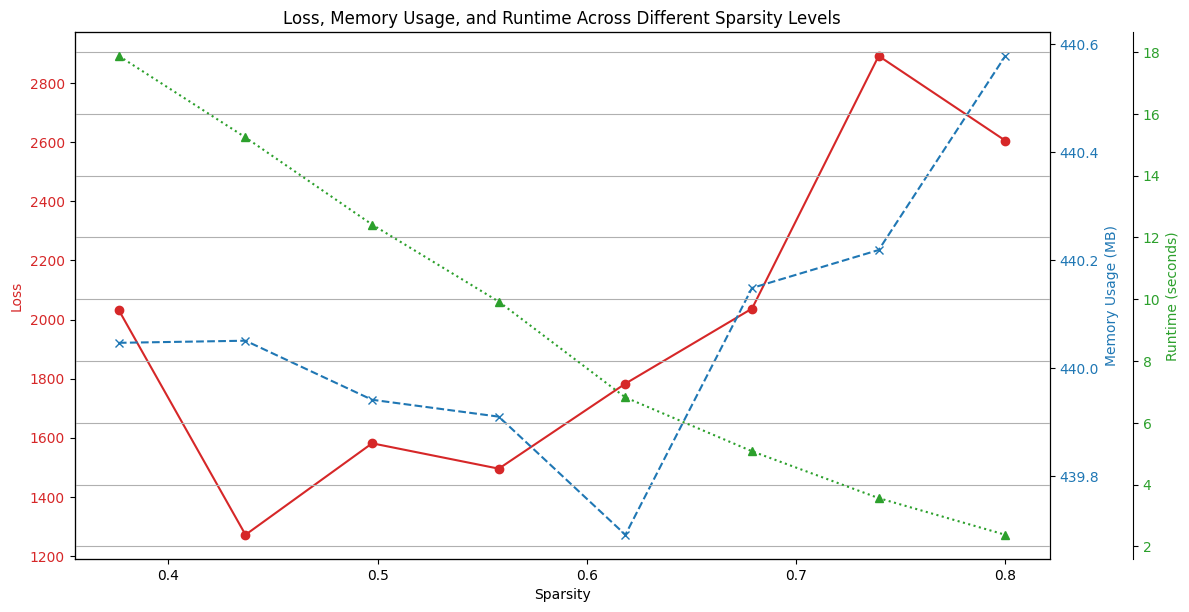

In [12]:
import pandas as pd
import time
import psutil
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)  # Return memory usage in MB
    
# Initialize logs for memory usage, runtime, and loss
memory_usage_log = []
runtime_log = []
loss_log = []

# Set random seed for reproducibility
np.random.seed(42)

# Set a fixed noise scale
noise_scale = 5

# Start training and recording
for sparsity in sparsity_set:
    print(f"\nTraining with sparsity: {sparsity:.2%}")

    # Generate the dataset
    users, books, ratings, followers = generate_dataset(
        follower_rating_ratio=follower_rating_ratio, 
        book_user_ratio=book_user_ratio, 
        sparsity=sparsity, 
        num_nodes=50, 
        genres=genres,
        epsilon=0.5, 
        sensitivity=1.0, 
        age_sensitivity=10.0
    )
    
    # Ensure data is in DataFrame format
    if not isinstance(users, pd.DataFrame):
        users = pd.DataFrame(users)
    if not isinstance(books, pd.DataFrame):
        books = pd.DataFrame(books)
    if not isinstance(ratings, pd.DataFrame):
        ratings = pd.DataFrame(ratings)
    if not isinstance(followers, pd.DataFrame):
        followers = pd.DataFrame(followers)

    # Record start time
    start_time = time.time()

    # Initialize preprocessor and model manager
    preprocessor = DataPreprocessing()
    model_class = GCN  # Assuming GCN is already defined

    # Preprocess data
    features, user_map, book_map, user_rated_books, edge_index, edge_weight, rule_scores, user_preferences = preprocessor.preprocess_data(users, books, ratings, followers)

    # Initialize the trainer
    trainer = GCNTrainer(GCN, features, user_map, book_map, user_preferences, rule_scores, user_rated_books, noise_scale, patience = 10)

    # Train and evaluate the model
    result = trainer.train_and_evaluate_model(features, edge_index, edge_weight)

    # Record the final loss, memory usage, and total runtime after training
    end_time = time.time()
    total_runtime = end_time - start_time  # Already calculated in train_model
    memory_usage = get_memory_usage()
    final_loss = result[noise_scale]['train_losses'][-1]  # Get the last loss as the final loss

    runtime_log.append(total_runtime)
    memory_usage_log.append(memory_usage)
    loss_log.append(final_loss)

    print(f"Completed training with sparsity {sparsity:.2f}, runtime: {total_runtime:.2f} sec, memory usage: {memory_usage:.2f} MB, loss: {final_loss:.4f}")

# Plot loss, memory usage, and runtime against sparsity

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Sparsity')
ax1.set_ylabel('Loss', color=color)
ax1.plot(sparsity_set, loss_log, marker='o', color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Memory Usage (MB)', color=color)
ax2.plot(sparsity_set, memory_usage_log, marker='x', linestyle='--', color=color, label='Memory Usage')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis outward
color = 'tab:green'
ax3.set_ylabel('Runtime (seconds)', color=color)
ax3.plot(sparsity_set, runtime_log, marker='^', linestyle=':', color=color, label='Runtime')
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Adjust layout to prevent overlap
plt.title('Loss, Memory Usage, and Runtime Across Different Sparsity Levels')
plt.grid(True)
plt.show()